In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine
from datetime import datetime, date, timedelta
import json
import pickle
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# London Cycle Hire
## So, where do people cycle

A look into London Cycle Hire data from 2017.

### Good ol' [data.london.gov.uk](data.london.gov.uk)

TFL regularly publishes all cycle hire journeys, generally collated by month and year. [Here](https://data.world/makeovermonday/london-cycle-hire-usage) we can find a version of the 2017 data where each record has had the start and end point mapped to the relevant data, rather than giving just an Id.

Now we have start and end location and timestamp, along with information about the relevant docking station (lat, lon, capacity, name) for each journey for the year.

In [2]:
d = pd.read_csv('tfl_cycle_hire_2017.csv')

In [3]:
d.to_pickle('tfl_cycle_hire_2017_base.pkl')

In [4]:
print(d.shape)
d.head()

(10011238, 18)


,startstation_lat,startstation_lon,startstaton_docks,endstation_lat,endstation_lon,endstationdocks,rental_id,duration,bike_id,startdate,startstation_id,startstation_name,enddate,endstation_id,endstation_name,year,startstation_location,endstation_location
0,51.490163,-0.190393,29,51.490945,-0.18119,30,63751445,180,3428,2017-04-05T22:47:00,219,"Bramham Gardens, Earl's Court",2017-04-05T22:50:00,216,"Old Brompton Road, South Kensington",2017,POINT(-0.190393 51.490163),POINT(-0.18119 51.490945)
1,51.490163,-0.190393,29,51.490945,-0.18119,30,64016293,180,13909,2017-04-12T21:41:00,219,"Bramham Gardens, Earl's Court",2017-04-12T21:44:00,216,"Old Brompton Road, South Kensington",2017,POINT(-0.190393 51.490163),POINT(-0.18119 51.490945)
2,51.490163,-0.190393,29,51.490945,-0.18119,30,64334332,180,11693,2017-04-23T19:20:00,219,"Bramham Gardens, Earl's Court",2017-04-23T19:23:00,216,"Old Brompton Road, South Kensington",2017,POINT(-0.190393 51.490163),POINT(-0.18119 51.490945)
3,51.490163,-0.190393,29,51.490945,-0.18119,30,64567541,240,4552,2017-05-01T20:12:00,219,"Bramham Gardens, Earl's Court",2017-05-01T20:16:00,216,"Old Brompton Road, South Kensington",2017,POINT(-0.190393 51.490163),POINT(-0.18119 51.490945)
4,51.490163,-0.190393,29,51.490945,-0.18119,30,64787260,180,5270,2017-05-08T19:44:00,219,"Bramham Gardens, Earl's Court",2017-05-08T19:47:00,216,"Old Brompton Road, South Kensington",2017,POINT(-0.190393 51.490163),POINT(-0.18119 51.490945)


To start with, we can reduce the dataset a bit by looking at a specific day. Why not use April 5th, a Wednesday coming a week or so before Easter that year.

In [5]:
d = d[d['startdate'].apply(lambda t: t.split('T')[0]) == '2017-04-05']
d['startdate'] = pd.to_datetime(d['startdate'])
d['enddate'] = pd.to_datetime(d['enddate'])
d = d.sort_values(by='startdate').reset_index(drop=True)
print(d.shape)
d.head(5)

(32410, 18)


,startstation_lat,startstation_lon,startstaton_docks,endstation_lat,endstation_lon,endstationdocks,rental_id,duration,bike_id,startdate,startstation_id,startstation_name,enddate,endstation_id,endstation_name,year,startstation_location,endstation_location
0,51.494470,-0.014409,17,51.491090,-0.018716,36,63716602,300,9375,2017-04-05 00:00:00,455,"East Ferry Road, Cubitt Town",2017-04-05 00:05:00,477,"Spindrift Avenue, Millwall",2017,POINT(-0.014409 51.49447),POINT(-0.018716 51.49109)
1,51.522561,-0.054883,24,51.516000,-0.038775,26,63716600,900,14760,2017-04-05 00:00:00,501,"Cephas Street, Bethnal Green",2017-04-05 00:15:00,461,"Aston Street, Stepney",2017,POINT(-0.054883 51.522561),POINT(-0.038775 51.516)
2,51.520260,-0.157183,18,51.532560,-0.168620,26,63716601,420,10921,2017-04-05 00:00:00,43,"Crawford Street, Marylebone",2017-04-05 00:07:00,590,"Greenberry Street, St.John's Wood",2017,POINT(-0.157183 51.52026),POINT(-0.16862 51.53256)
3,51.483732,-0.223852,36,51.488108,-0.226606,46,63716603,180,387,2017-04-05 00:01:00,644,"Rainville Road, Hammersmith",2017-04-05 00:04:00,682,"Crisp Road, Hammersmith",2017,POINT(-0.223852 51.483732),POINT(-0.226606 51.488108)
4,51.500401,-0.195455,19,51.515607,-0.183118,16,63716605,660,4943,2017-04-05 00:02:00,168,"Argyll Road, Kensington",2017-04-05 00:13:00,164,"Cleveland Gardens, Bayswater",2017,POINT(-0.195455 51.500401),POINT(-0.183118 51.515607)


### Speed / Urgency / Get-to-the-point-edness

Obviously any straight line distance is not the actual distance travelled.
However while the 'speed' over this distance isn't exactly Strava-worthy, it is still a bit useful for taking some measure of how much people wanted to get to their destination, or alternatively how little they were stuck in traffic.

In [18]:
d['distance'] = d.apply(lambda row: haversine((row['startstation_lat'], row['startstation_lon']), (row['endstation_lat'], row['endstation_lon'])), axis=1)
d['speed'] = d['distance'] / d['duration'] * 3600
d = d.replace(np.inf, np.nan)

In [7]:
d.head()

,startstation_lat,startstation_lon,startstaton_docks,endstation_lat,endstation_lon,endstationdocks,rental_id,duration,bike_id,startdate,startstation_id,startstation_name,enddate,endstation_id,endstation_name,year,startstation_location,endstation_location,distance,speed
0,51.494470,-0.014409,17,51.491090,-0.018716,36,63716602,300,9375,2017-04-05 00:00:00,455,"East Ferry Road, Cubitt Town",2017-04-05 00:05:00,477,"Spindrift Avenue, Millwall",2017,POINT(-0.014409 51.49447),POINT(-0.018716 51.49109),0.479756,5.757075
1,51.522561,-0.054883,24,51.516000,-0.038775,26,63716600,900,14760,2017-04-05 00:00:00,501,"Cephas Street, Bethnal Green",2017-04-05 00:15:00,461,"Aston Street, Stepney",2017,POINT(-0.054883 51.522561),POINT(-0.038775 51.516),1.332075,5.328300
2,51.520260,-0.157183,18,51.532560,-0.168620,26,63716601,420,10921,2017-04-05 00:00:00,43,"Crawford Street, Marylebone",2017-04-05 00:07:00,590,"Greenberry Street, St.John's Wood",2017,POINT(-0.157183 51.52026),POINT(-0.16862 51.53256),1.580069,13.543451
3,51.483732,-0.223852,36,51.488108,-0.226606,46,63716603,180,387,2017-04-05 00:01:00,644,"Rainville Road, Hammersmith",2017-04-05 00:04:00,682,"Crisp Road, Hammersmith",2017,POINT(-0.223852 51.483732),POINT(-0.226606 51.488108),0.522621,10.452412
4,51.500401,-0.195455,19,51.515607,-0.183118,16,63716605,660,4943,2017-04-05 00:02:00,168,"Argyll Road, Kensington",2017-04-05 00:13:00,164,"Cleveland Gardens, Bayswater",2017,POINT(-0.195455 51.500401),POINT(-0.183118 51.515607),1.894181,10.331894


So, unsurprisingly actually, what are probably super early morning commuters are the fastest.

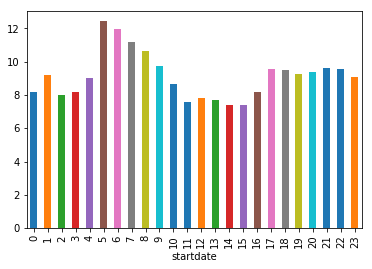

In [20]:
d.groupby(d.startdate.dt.hour).mean()['speed'].plot(kind='bar')

## Create dict of bikepoints and their details

Using the response from the tfl get-all-stops api endpoint

In [26]:
with open('bikepoints.json') as bikepoints:
    bp = json.load(bikepoints)

In [27]:
bp[13]

{'$type': 'Tfl.Api.Presentation.Entities.Place, Tfl.Api.Presentation.Entities',
 'id': 'BikePoints_14',
 'url': '/Place/BikePoints_14',
 'commonName': "Belgrove Street , King's Cross",
 'placeType': 'BikePoint',
 'additionalProperties': [{'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities',
   'category': 'Description',
   'key': 'TerminalName',
   'sourceSystemKey': 'BikePoints',
   'value': '001011',
   'modified': '2018-09-01T11:22:28.603Z'},
  {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities',
   'category': 'Description',
   'key': 'Installed',
   'sourceSystemKey': 'BikePoints',
   'value': 'true',
   'modified': '2018-09-01T11:22:28.603Z'},
  {'$type': 'Tfl.Api.Presentation.Entities.AdditionalProperties, Tfl.Api.Presentation.Entities',
   'category': 'Description',
   'key': 'Locked',
   'sourceSystemKey': 'BikePoints',
   'value': 'false',
   'modified': '2018-09-01T11:22:28.603Z'},
  {'$type':

In [28]:
bike_points = dict()
wanted = ['InstallDate', 'NbDocks']
for point in bp:
    
    props = dict()
    for cat in point['additionalProperties']:
        if cat['key'] in wanted:
            props[cat['key']] = cat['value']
            
    
    id_ = point['id'].split('_')[-1]
    props['name'] = point['commonName']
    try:
        bike_points[int(id_)] = props
    except Exception:
        print(f'failed for {id_}')

In [30]:
bike_points[154]

{'InstallDate': '', 'NbDocks': '35', 'name': 'Waterloo Station 3, Waterloo'}

## Where do people use the most

Looking like IDs 14, 191, 154, 303, 374 etc are the most used for both rentals and returns.

In [41]:
d.startstation_id.value_counts()[:10]

14     381
154    364
191    306
303    258
374    220
248    214
307    206
111    188
217    185
55     161
101    161
194    154
251    154
104    141
427    141
Name: startstation_id, dtype: int64

In [40]:
d.endstation_id.value_counts()[:10]

14     362
191    309
154    302
303    258
374    229
248    204
217    200
307    200
194    194
111    184
Name: endstation_id, dtype: int64

In [45]:
n = 8
top_ids = set(pd.Series(d.startstation_id.value_counts())[:n].index) | set(pd.Series(d.endstation_id.value_counts())[:n].index)


for id_ in top_ids:
    print(id_, bike_points[id_])

14 {'InstallDate': '1278341040000', 'NbDocks': '48', 'name': "Belgrove Street , King's Cross"}
303 {'InstallDate': '1279812720000', 'NbDocks': '28', 'name': 'Albert Gate, Hyde Park'}
111 {'InstallDate': '1279109160000', 'NbDocks': '28', 'name': 'Park Lane , Hyde Park'}
307 {'InstallDate': '1279816500000', 'NbDocks': '24', 'name': 'Black Lion Gate, Kensington Gardens'}
374 {'InstallDate': '1291725720000', 'NbDocks': '36', 'name': 'Waterloo Station 1, Waterloo'}
248 {'InstallDate': '1279640160000', 'NbDocks': '27', 'name': 'Triangle Car Park, Hyde Park'}
217 {'InstallDate': '1279538040000', 'NbDocks': '16', 'name': 'Wormwood Street, Liverpool Street'}
154 {'InstallDate': '', 'NbDocks': '35', 'name': 'Waterloo Station 3, Waterloo'}
191 {'InstallDate': '1279383120000', 'NbDocks': '28', 'name': 'Hyde Park Corner, Hyde Park'}


## Lets pull out some totals

I want to see the biggest net changes. Where goes the deepest in or out during the day.

In [46]:
point_data = []

points = set(d['startstation_id']) | set(d['endstation_id'])

point_dict = dict()
for k in points:
    point_dict[int(k)] = {'in': 0, 'out': 0, 'net': 0}
    
for i, row in d.iterrows():
    p_from = row['startstation_id']
    p_to = row['endstation_id']
    timestamp_from = row['startdate']
    timestamp_to = row['enddate']
    
    point_dict[p_from]['net'] = point_dict[p_from]['net'] - 1
    point_dict[p_from]['out'] = point_dict[p_from]['out'] + 1
    item = (timestamp_from, p_from, point_dict[p_from]['net'])
    point_data.append(item)
    
    
    point_dict[p_to]['net'] = point_dict[p_to]['net'] + 1
    point_dict[p_to]['in'] = point_dict[p_to]['in'] + 1
    item = (timestamp_to, p_to, point_dict[p_to]['net'])
    point_data.append(item)

In [55]:
pdpd = pd.DataFrame(point_data)
pdpd.columns = ['date', 'point_id', 'net']
pdpd = pdpd.sort_values(by="net")
pdpd.head()

,date,point_id,net
24768,2017-04-05 12:28:00,154,-312
23652,2017-04-05 12:02:00,154,-312
26756,2017-04-05 13:10:00,154,-311
24726,2017-04-05 12:27:00,154,-311
22176,2017-04-05 11:24:00,154,-311


What is the most that each point went up over the day, assuming we start the day from zero. This should find things like common places of work or popular night destinations.

In [58]:
most_to = pdpd.groupby(['point_id']).max().sort_values(by='net', ascending=False).reset_index()
most_to.columns = list(most_to.columns)[:-1] + ['max_net']
most_to = most_to.drop('date', axis=1)
most_to

,point_id,max_net
0,71,105
1,228,92
2,66,83
3,427,75
4,109,73
5,703,65
6,194,57
7,251,54
8,436,54
9,27,52


Similarly, what is the most each point went down, this is better for finding train stations.

In [59]:
most_from = pdpd.groupby(['point_id']).min().sort_values(by='net', ascending=True).reset_index()
most_from.columns = list(most_from.columns)[:-1] + ['min_net']
most_from = most_from.drop('date', axis=1)
most_from

,point_id,min_net
0,154,-312
1,14,-269
2,374,-167
3,361,-112
4,574,-57
5,45,-41
6,25,-38
7,93,-37
8,449,-36
9,798,-35


In [60]:
most = pd.merge(most_from, most_to, on="point_id")
most.head()

,point_id,min_net,max_net
0,154,-312,-1
1,14,-269,0
2,374,-167,10
3,361,-112,-1
4,574,-57,-1


In [61]:
most['total_in'] = most['point_id'].apply(lambda x: point_dict.get(x, {'in': np.nan})['in'])
most['total_out'] = most['point_id'].apply(lambda x: point_dict.get(x, {'out': np.nan})['out'])

In [63]:
dock_capacity = dict(zip(d['startstation_id'], d['startstaton_docks']))

most['capacity'] = most['point_id'].map(dock_capacity)
most['place'] = most['point_id'].apply(lambda x: bike_points.get(x, {'name': ''})['name'])

Lets find places that definitely overran their capacity at some point during the day.
This means that their biggest net change was greater than the capacity of the station, and that it definitely needed a delivery or removal at some point.

Since we don't have the starting state it is impossible to say if other's needed this (eg it started almost empty and was refilled 5 bikes down in the morning).

In [64]:
most['max_from'] = abs(most['min_net']) - most['capacity']
most['max_to'] = abs(most['max_net']) - most['capacity']
most['day_net'] = most['total_in'] + most['total_out']
most

,point_id,min_net,max_net,total_in,total_out,capacity,place,max_from,max_to,day_net
0,154,-312,-1,302,364,35,"Waterloo Station 3, Waterloo",277,-34,666
1,14,-269,0,362,381,48,"Belgrove Street , King's Cross",221,-48,743
2,374,-167,10,229,220,36,"Waterloo Station 1, Waterloo",131,-26,449
3,361,-112,-1,85,117,55,"Waterloo Station 2, Waterloo",57,-54,202
4,574,-57,-1,64,106,45,"Eagle Wharf Road, Hoxton",12,-44,170
5,45,-41,-1,47,64,26,"Boston Place, Marylebone",15,-25,111
6,25,-38,2,57,64,31,"Doric Way , Somers Town",7,-29,121
7,93,-37,0,34,50,37,"Cloudesley Road, Angel",0,-37,84
8,449,-36,-1,53,65,35,"Shadwell Station, Shadwell",1,-34,118
9,798,-35,2,54,61,27,"Birkenhead Street, King's Cross",8,-25,115


In [70]:
print(f"These 124 stations were definitely treated to addition or removal of bikes during the day. That is {len(diffs) / len(set(d['startstation_id'])) * 100}%")

These 124 stations were definitely treated to addition or removal of bikes during the day. That is 16.25163826998689%


In [75]:
diffs = most[(most['max_from'] > 0) | (most['max_to'] > 0)]

print(f"These {len(diffs)} stations were definitely treated to addition or removal of bikes during the day. That is {len(diffs) / len(set(d['startstation_id'])) * 100}% of the total.")

These 124 stations were definitely treated to addition or removal of bikes during the day. That is 16.25163826998689% of the total.


In [76]:
diffs.sort_values(by="max_from", ascending=False)

,point_id,min_net,max_net,total_in,total_out,capacity,place,max_from,max_to,day_net
0,154,-312,-1,302,364,35,"Waterloo Station 3, Waterloo",277,-34,666
1,14,-269,0,362,381,48,"Belgrove Street , King's Cross",221,-48,743
2,374,-167,10,229,220,36,"Waterloo Station 1, Waterloo",131,-26,449
3,361,-112,-1,85,117,55,"Waterloo Station 2, Waterloo",57,-54,202
15,290,-30,3,107,106,15,"Winsland Street, Paddington",15,-12,213
5,45,-41,-1,47,64,26,"Boston Place, Marylebone",15,-25,111
4,574,-57,-1,64,106,45,"Eagle Wharf Road, Hoxton",12,-44,170
9,798,-35,2,54,61,27,"Birkenhead Street, King's Cross",8,-25,115
39,186,-23,10,83,79,16,"South Wharf Road, Paddington",7,-6,162
34,189,-25,1,12,37,18,"Claremont Square, Angel",7,-17,49


In [64]:
diffs.sort_values(by="max_to", ascending=False)

,point_id,min_net,max_net,total_in,total_out,capacity,place,max_from,max_to,day_net
724,71,1,105,158,-110,34,"Newgate Street , St. Paul's",-33,71,48
711,228,1,92,164,-121,40,"St. James's Square, St. James's",-39,52,43
720,66,1,83,124,-103,40,"Holborn Circus, Holborn",-39,43,21
732,703,1,65,104,-60,25,"St. Bride Street, Holborn",-24,40,44
734,427,1,75,148,-141,43,"Cheapside, Bank",-42,32,7
691,546,1,48,81,-64,21,"New Fetter Lane, Holborn",-20,27,17
595,278,-1,42,105,-82,17,"Tooley Street, Bermondsey",-16,25,23
672,217,0,40,200,-185,16,"Wormwood Street, Liverpool Street",-16,24,15
761,48,1,48,97,-72,25,"Godliman Street, St. Paul's",-24,23,25
697,175,1,47,76,-51,26,"Worship Street, Shoreditch",-25,21,25


## So, Where do people go?

Well, the bike points handing out the most bikes beyond their capacity are almost all major rail stations.

As for where people go, lots of banking and governmental sectors at the top, but nowhere near the imbalance we see with people taking them out.